In [ ]:
# -*- coding: utf-8 -*-
"""

This script performs the following tasks:

1. Uses as input the weights from a run of the Convolutional Variational Autoencoder (CVAE) from the TensorFlow tutorial.
2. Uses as input the latent space of the MNIST dataset encoded through CVAE.

The script implements both the encoder and decoder as functions.

Authors:
- Gabriel Turinici
- Tiffany Zeitoun
- Dan Winzsman
- Benjamin Krief
"""

# Import necessary libraries for deep learning, visualization, and data processing
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # For displaying progress bars during training or data loading
import pandas as pd  # For handling data operations and analysis


In [ ]:
# Print a message indicating the download process is starting
print('Downloading necessary files')

# Import the requests library for handling file downloads
import requests

# Base URL for downloading the required files
base_url = 'https://github.com/gabriel-turinici/Huber-energy-measure-quantization/raw/main/diversity_in_generative_ai/'

# List of file names to be downloaded
files_names = ['my_checkpoint.index', 'reparam.npz', 'my_checkpoint.data-00000-of-00001']

# Loop through the list of files and download each one
for fl in files_names:
    print(f'Downloading {fl} from {base_url}')  # Inform the user which file is being downloaded
    response = requests.get(base_url + fl)  # Send a request to download the file
    with open(fl, mode="wb") as file:  # Open the file in write-binary mode
        file.write(response.content)  # Write the downloaded content to the file


download necessary files
downloading my_checkpoint.index from https://github.com/gabriel-turinici/Huber-energy-measure-quantization/raw/main/diversity_in_generative_ai/
downloading reparam.npz from https://github.com/gabriel-turinici/Huber-energy-measure-quantization/raw/main/diversity_in_generative_ai/
downloading my_checkpoint.data-00000-of-00001 from https://github.com/gabriel-turinici/Huber-energy-measure-quantization/raw/main/diversity_in_generative_ai/


In [ ]:
def preprocess_images(images):
    """
    Preprocess the input images by reshaping and normalizing pixel values.

    Args:
        images (numpy array): Array of images to be preprocessed.

    Returns:
        numpy array: Preprocessed images, reshaped to (28, 28, 1) and normalized to float32.
    """
    # Reshape the images to add a channel dimension (28x28 images with 1 channel)
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.0  # Normalize pixel values to [0, 1] range
    
    return images.astype('float32')


In [ ]:
# Load and preprocess the MNIST dataset
print('Loading MNIST dataset and preprocessing images')

# Load the MNIST dataset from TensorFlow's built-in datasets (we only need the images, not the labels)
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

# Define a function to preprocess MNIST images
def preprocess_images(images):
    """
    Preprocess the input images by reshaping, normalizing, and binarizing pixel values.

    Args:
        images (numpy array): Array of images to preprocess.

    Returns:
        numpy array: Preprocessed images, reshaped to (28, 28, 1), normalized and binarized.
    """
    # Reshape the images to add a channel dimension (28x28 images with 1 channel) and normalize pixel values
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.0

    # Binarize pixel values: set values > 0.5 to 1.0 and others to 0.0
    return np.where(images > 0.5, 1.0, 0.0).astype('float32')

# Preprocess the training and testing images
train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

# Display the shape of the preprocessed training images
print('Shape of preprocessed train_images:', train_images.shape)


load mnist, preprocess images
11490434/11490434 [==============================] - 0s 0us/step
train_image.shape= (60000, 28, 28, 1)


In [ ]:
N = 2  # Ambient dimension for latent space

class CVAE(tf.keras.Model):
    """Convolutional Variational Autoencoder (CVAE) class definition."""

    def __init__(self, latent_dim):
        """
        Initialize the CVAE model.
        
        Args:
            latent_dim (int): Dimensionality of the latent space.
        """
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim

        # Define the encoder network as a Sequential model
        self.encoder = tf.keras.Sequential(
            [
                # Input layer: shape of the input is (28, 28, 1) for MNIST images
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                
                # Flatten the input image into a 1D vector
                tf.keras.layers.Flatten(),
                
                # Add 5 fully connected layers with ReLU activation
                *[tf.keras.layers.Dense(28 * 28, activation='relu') for _ in range(5)],
                
                # The final layer outputs both mean and log variance for reparameterization
                tf.keras.layers.Dense(latent_dim + latent_dim)  # Output latent_dim for mean and logvar
            ]
        )

        # Define the decoder network as a Sequential model
        self.decoder = tf.keras.Sequential(
            [
                # Input layer: latent space input of shape (latent_dim,)
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),

                # Flatten the latent vector (though it's already 1D in this case)
                tf.keras.layers.Flatten(),

                # Add fully connected layers to reconstruct the original image
                *[tf.keras.layers.Dense(28 * 28, activation='relu') for _ in range(4)],

                # The final layer reshapes the output back to (28, 28, 1) for the image
                tf.keras.layers.Dense(28 * 28),  # Output logits without activation
                tf.keras.layers.Reshape((28, 28, 1))  # Reshape the output to match the original image size
            ]
        )

    @tf.function
    def sample(self, eps=None):
        """
        Generate samples from the latent space by decoding random or given points.

        Args:
            eps (tensor, optional): Latent space points. If not provided, random points are sampled.
        
        Returns:
            tensor: Decoded output from latent space points, typically images.
        """
        if eps is None:
            # If no latent points are provided, generate random points from a normal distribution
            eps = tf.random.normal(shape=(100, self.latent_dim))
        
        # Decode the latent space points into images
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        """
        Encodes the input images into the latent space.
        
        Args:
            x (tensor): Input image data.
        
        Returns:
            tuple: Mean and log variance of the encoded latent variables.
        """
        # Split the encoder output into mean and log variance for the latent space
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        """
        Reparameterization trick to sample from a normal distribution using the mean and log variance.
        
        Args:
            mean (tensor): Mean of the latent variables.
            logvar (tensor): Log variance of the latent variables.
        
        Returns:
            tensor: Sampled latent variables.
        """
        # Sample random noise from a standard normal distribution
        eps = tf.random.normal(shape=mean.shape)
        
        # Reparameterize to generate latent variables
        return eps * tf.exp(logvar * 0.5) + mean

    def decode(self, z, apply_sigmoid=False):
        """
        Decodes the latent variables back into images.
        
        Args:
            z (tensor): Latent variables.
            apply_sigmoid (bool, optional): Whether to apply the sigmoid function to the output.
        
        Returns:
            tensor: Decoded output, typically images.
        """
        # Pass the latent variables through the decoder network to reconstruct images
        logits = self.decoder(z)

        # Apply sigmoid activation if specified (useful for binary outputs)
        if apply_sigmoid:
            return tf.sigmoid(logits)
        
        return logits  # Return the raw logits if no sigmoid is applied


In [ ]:
latent_dim = 2  # Set the dimensionality of the latent space

# Create a new instance of the CVAE model
print('Creating a new CVAE model instance')
model = CVAE(latent_dim)

# Generate a sample from the model using a random latent vector
res = model.sample(np.random.randn(1, latent_dim))  # Sampling from a random latent vector

# Uncomment the following line if you want to generate and save images using a custom function
# generate_and_save_images(model, 0, test_sample)

# Set the model's 'built' attribute to True to allow loading weights
model.built = True

# Restore the model weights from a checkpoint
print('Restoring model weights from checkpoint')

# Ensure that you are in the correct directory where the "my_checkpoint.index" file is located
model.load_weights("./my_checkpoint")


Create a new model instance
restore weights


In [ ]:
def decoder_function(latent, digit_size=28):
    """
    Decoder function: Takes a latent vector as input and outputs a 28x28 image.
    
    Args:
        latent (tensor): Latent vector of shape (latent_dim,).
        digit_size (int): Size of the output image, default is 28 (for 28x28 image).
    
    Returns:
        tensor: Decoded image of shape (digit_size, digit_size).
    """
    # Ensure the latent vector has the correct shape
    assert latent.shape == (latent_dim,), 'Error: input latent vector has incorrect shape'
    
    # Pass the latent vector through the model's decoder to generate the image
    x_decoded = model.sample(latent[None, :])  # Add batch dimension
    
    # Reshape the output into a 28x28 image
    digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
    
    return digit


def encoder_function(image, digit_size=28):
    """
    Encoder function: Takes an image as input and outputs a latent vector.
    
    Args:
        image (tensor): Input image of shape (digit_size, digit_size).
        digit_size (int): Size of the input image, default is 28 (for 28x28 image).
    
    Returns:
        tensor: Latent vector of shape (latent_dim,).
    """
    # Ensure the input image has the correct shape
    assert image.shape == (digit_size, digit_size), 'Error: input image has incorrect shape'
    
    # Reshape the image to add the necessary batch and channel dimensions, then pass through the encoder
    res = model.encoder(tf.reshape(image, (1, digit_size, digit_size, 1)))  # Add batch and channel dimensions
    
    # Return the latent vector (taking only the first 'latent_dim' values)
    return res[0, :latent_dim]


In [ ]:
# Adjust the display options for NumPy arrays
np.set_printoptions(threshold=np.inf, linewidth=np.inf)  # Ensures full array output without truncation

# Load the NumPy array from the 'reparam.npz' file
with np.load('reparam.npz', allow_pickle=True) as data:
    reparam = data['reparam']  # Extract the 'reparam' array from the file

# Uncomment the line below if you wish to print the entire first element of the array
# print(reparam[0])

In [ ]:
# Import necessary modules for working with files and Google Drive
from google.colab import files
from google.colab import drive
import ast

# Mount Google Drive to access files
drive.mount('/content/drive')

# Function to retrieve solutions from a file and convert them into a list of Python objects
def recup_solutions(filepath=''):
    """
    Retrieve solutions from a file and parse each line as a Python object.
    
    Args:
        filepath (str): Path to the file containing solutions.
    
    Returns:
        list: A list of parsed solutions from the file.
    """
    with open(filepath, 'r') as file:
        solutions = [ast.literal_eval(line.strip()) for line in file]  # Convert each line to a Python object
    return solutions

# Function to retrieve a list of floats from a file
def recup_da_floats(filepath):
    """
    Retrieve a list of floats from a comma-separated file.
    
    Args:
        filepath (str): Path to the file containing floats.
    
    Returns:
        list: A list of floats.
    """
    with open(filepath, 'r') as file:
        data = file.read().strip().split(',')  # Split the file content by commas
        float_list = [float(x) for x in data]  # Convert each element to a float
    return float_list

# Define the file paths for the required data
filepath_final_errors = '/content/drive/My Drive/Thesis/data/final_errors.txt'
filepath_deltas = '/content/drive/My Drive/Thesis/data/deltas.txt'
filepath_solutions = '/content/drive/My Drive/Thesis/data/solutions.txt'
filepath_reparam = '/content/drive/My Drive/Thesis/data/reparam.txt'
filepath_bonus = '/content/drive/My Drive/Thesis/data/bonus.txt'

# Load data from the respective files
final_errors = recup_da_floats(filepath_final_errors)  # Load final errors as a list of floats
deltas = recup_da_floats(filepath_deltas)  # Load deltas as a list of floats
solutions = recup_solutions(filepath_solutions)  # Load solutions as a list of Python objects
reparam = np.array(recup_solutions(filepath_reparam))  # Load reparam as a NumPy array of solutions
bonus = np.array(recup_solutions(filepath_bonus))  # Load bonus as a NumPy array of solutions


Mounted at /content/drive


<ipython-input-16-01e18c71d09b>:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


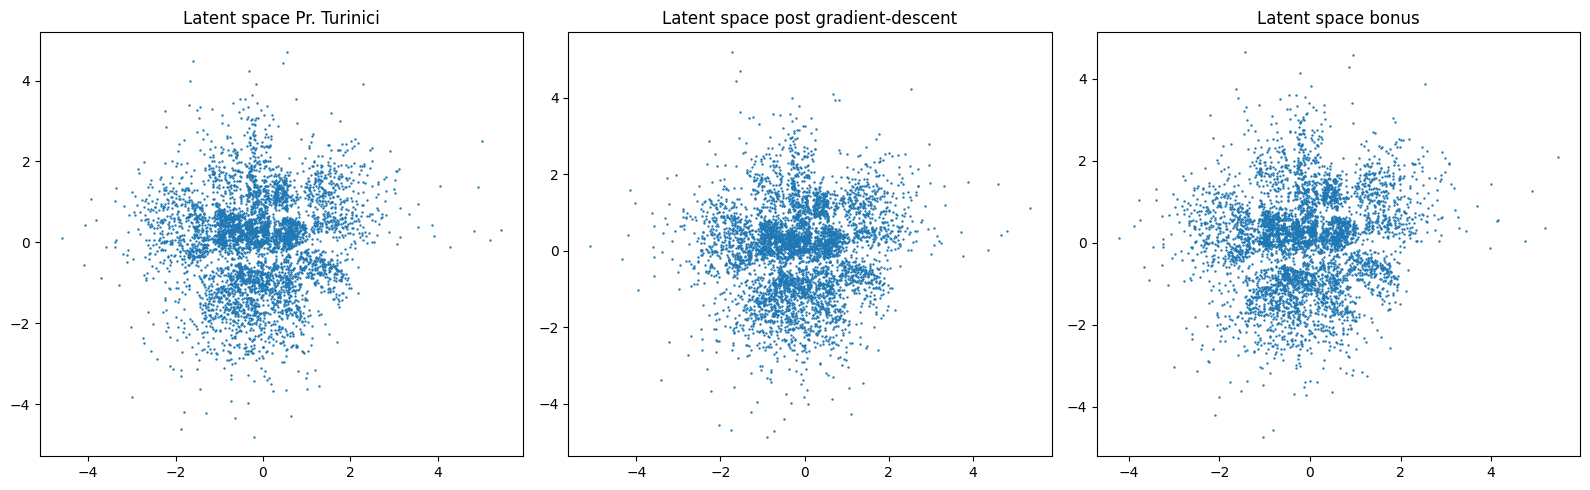

In [ ]:
# Create a figure with constrained layout and specified size
plt.figure(constrained_layout=True, figsize=(16, 5))

####################################################################################################################################################
# Plot for reparam
####################################################################################################################################################

plt.subplot(1, 3, 1)  # Create a subplot for the reparam data

# Use only the first 5000 points from reparam for visualization
reparam_subset = reparam[:5000]

# Randomly select 5000 indices from the subset
rnd = np.random.choice(list(range(reparam_subset.shape[0])), size=5000, replace=False)

# Create the scatter plot for the reparam latent space
plt.scatter(reparam_subset[rnd, 0], reparam_subset[rnd, 1], s=0.5)
plt.title("Latent space Pr. Turinici")
plt.tight_layout()

####################################################################################################################################################
# Plot for solutions
####################################################################################################################################################

plt.subplot(1, 3, 2)  # Create a subplot for the solutions data

# Extract x and y coordinates from the solutions list
x = [point[0] for point in solutions]
y = [point[1] for point in solutions]

# Randomly select 5000 indices from the solutions data
rnd_indices = np.random.choice(list(range(len(solutions))), size=5000, replace=False)

# Create the scatter plot for the latent space post gradient-descent
plt.scatter(np.array(x)[rnd_indices], np.array(y)[rnd_indices], s=0.5)
plt.title("Latent space post gradient-descent")
plt.tight_layout()

####################################################################################################################################################
# Plot for bonus
####################################################################################################################################################

plt.subplot(1, 3, 3)  # Create a subplot for the bonus data

# Extract x and y coordinates from the bonus list
a = [point[0] for point in bonus]
b = [point[1] for point in bonus]

# Randomly select 5000 indices from the bonus data
rnd_indices_bonus = np.random.choice(list(range(len(bonus))), size=5000, replace=False)

# Create the scatter plot for the bonus latent space
plt.scatter(np.array(a)[rnd_indices_bonus], np.array(b)[rnd_indices_bonus], s=0.5)
plt.title("Latent space bonus")
plt.tight_layout()

####################################################################################################################################################
# Show the plots
####################################################################################################################################################

plt.show()


<ipython-input-19-8a97a61b2cda>:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


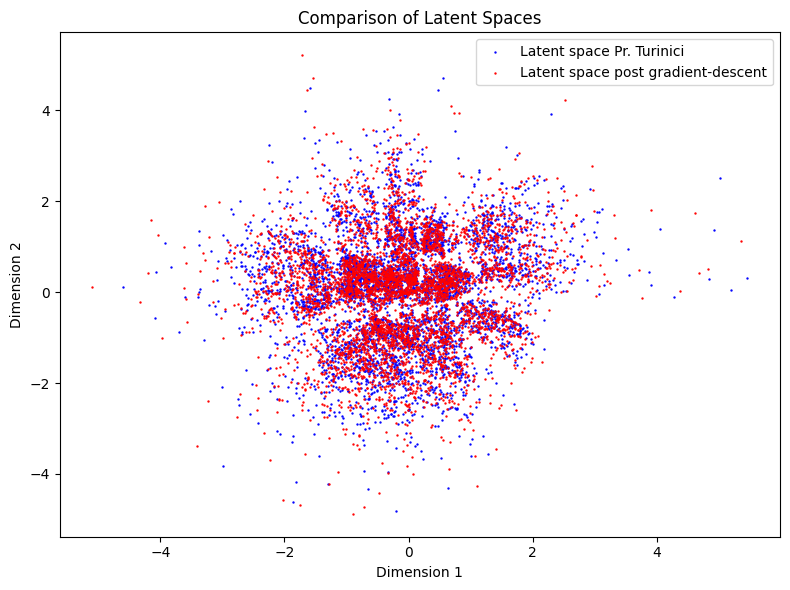

In [ ]:
# Create a figure with constrained layout and specified size
plt.figure(constrained_layout=True, figsize=(8, 6))

# Plot the reparam data in blue
plt.scatter(reparam_subset[rnd, 0], reparam_subset[rnd, 1], s=0.5, c='blue', label="Latent space Pr. Turinici")

# Plot the solutions data in red
plt.scatter(np.array(x)[rnd_indices], np.array(y)[rnd_indices], s=0.5, c='red', label="Latent space post gradient-descent")

####################################################################################################################################################
# Comparison of Latent Spaces
####################################################################################################################################################

# Set the title of the plot
plt.title("Comparison of Latent Spaces")

# Label the x and y axes
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

# Add a legend to differentiate the data sets
plt.legend(loc='upper right')

# Adjust the layout to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()


<ipython-input-24-91ad853f83b7>:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


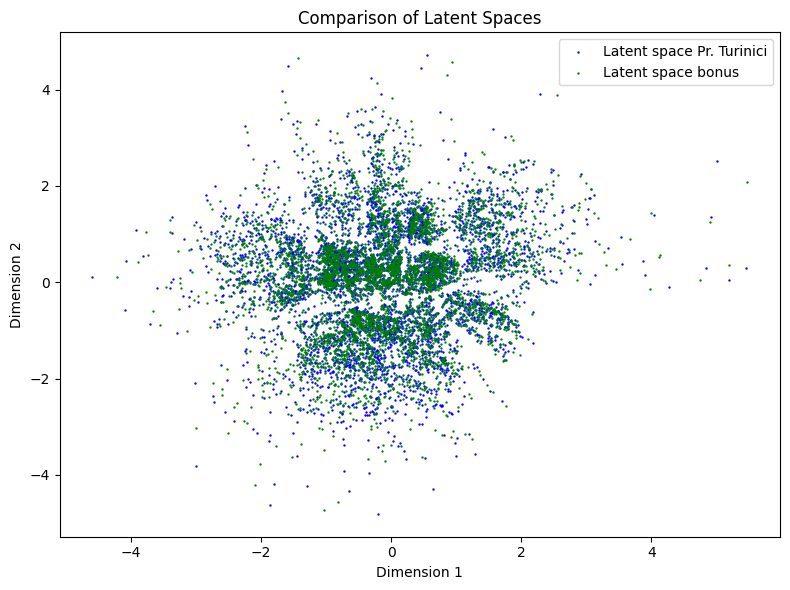

In [ ]:
# Create a figure with constrained layout and specified size
plt.figure(constrained_layout=True, figsize=(8, 6))

# Plot the reparam data in blue
plt.scatter(reparam_subset[rnd, 0], reparam_subset[rnd, 1], s=0.5, c='blue', label="Latent space Pr. Turinici")

# Plot the bonus data in green
plt.scatter(np.array(a)[rnd_indices_bonus], np.array(b)[rnd_indices_bonus], s=0.5, c='green', label="Latent space bonus")

####################################################################################################################################################
# Comparison of Latent Spaces
####################################################################################################################################################

# Set the title of the plot
plt.title("Comparison of Latent Spaces")

# Label the x and y axes
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

# Add a legend to differentiate between the datasets
plt.legend(loc='upper right')

# Adjust the layout to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
# Rename and store reparam and solutions data

# MT_space corresponds to the "Pr. Turinici" latent space (formerly reparam_subset)
MT_space = np.array(reparam_subset)  # Old latent space

# MN_space corresponds to the "post gradient-descent" latent space (formerly solutions)
MN_space = np.array(solutions)  # New latent space


In [ ]:
# Import necessary libraries for building and training the model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

# Function to build the model
def build_model(latent_dim):
    """
    Build a simple feedforward neural network with two hidden layers.

    Args:
        latent_dim (int): Dimensionality of the input and output.

    Returns:
        model (keras.Sequential): The compiled Keras model.
    """
    model = models.Sequential()
    
    # Input layer with the specified latent dimension
    model.add(layers.Input(shape=(latent_dim,)))
    
    # Two dense (fully connected) layers with ReLU activation
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    
    # Output layer with latent_dim neurons (matching the input dimension)
    model.add(layers.Dense(latent_dim))
    
    return model

# Determine the dimensionality of the latent space (from MT_space)
dim = len(MT_space[0])

# Build the bonus model using the latent dimension size
model_bonus = build_model(dim)

# Compile the model with Adam optimizer and mean squared error loss
model_bonus.compile(optimizer='adam', loss='mse')

# Train the model on the MT_space and MN_space with a validation split of 20%
model_bonus.fit(MT_space, MN_space, epochs=100, batch_size=32, validation_split=0.2)


Epoch 1/100
125/125 [==============================] - 2s 6ms/step - loss: 0.1918 - val_loss: 0.0143
Epoch 2/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0119 - val_loss: 0.0120
Epoch 3/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0108 - val_loss: 0.0119
Epoch 4/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0107 - val_loss: 0.0110
Epoch 5/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0105 - val_loss: 0.0110
Epoch 6/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0105 - val_loss: 0.0112
Epoch 7/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0107 - val_loss: 0.0114
Epoch 8/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0106 - val_loss: 0.0110
Epoch 9/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0105 - val_loss: 0.0109
Epoch 10/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0108 - val_lo

Quelle image voulez-vous tester (entre 0 et 4999) : 50
1/1 [==============================] - 0s 131ms/step


<Figure size 640x480 with 0 Axes>

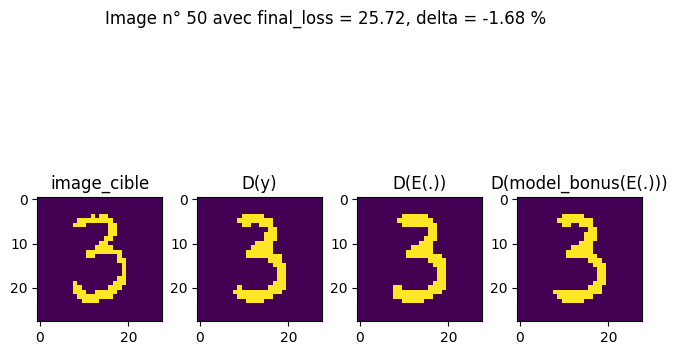

In [ ]:
def comparison_images(mnist_index, file_path_comparison='', save=False):
    """
    Compare the original MNIST image with various decoded outputs:
    1. The original target image.
    2. The decoded solution (y) from gradient descent.
    3. The decoded image from the encoder-decoder pipeline applied to the original image.
    4. The decoded image from model_bonus applied to the encoded original image.

    Args:
        mnist_index (int): Index of the image from the MNIST dataset.
        file_path_comparison (str): File path to save the comparison plot, if save is True.
        save (bool): If True, save the plot to file_path_comparison and download the file.
    """
    # Fetch the target MNIST image for the given index
    image_cible = train_images[mnist_index, :, :, 0]  # Original MNIST image at mnist_index
    y = tf.Variable(solutions[mnist_index])  # Corresponding solution (latent space) for the image

    # Create a figure for plotting the comparisons
    plt.figure(constrained_layout=True)
    
    ####################################################################################################################################################
    # Subplot 1: Plot the original MNIST image
    ####################################################################################################################################################
    plt.subplot(1, 4, 1)
    plt.imshow(image_cible, cmap='gray')  # Plot the original image
    plt.title("Original Image")

    ####################################################################################################################################################
    # Subplot 2: Plot the decoded image from the solution found with gradient descent (D(y))
    ####################################################################################################################################################
    plt.subplot(1, 4, 2)
    dec_function_np = decoder_function(y)  # Decode the solution from latent space
    plt.imshow(np.where(dec_function_np > 0.5, 1.0, 0.0), cmap='gray')  # Binarize and plot
    plt.title("D(y)")

    ####################################################################################################################################################
    # Subplot 3: Plot the decoded image from the encoder-decoder applied to the original image (D(E(.)))
    ####################################################################################################################################################
    plt.subplot(1, 4, 3)
    dec_enc_image_cible = decoder_function(encoder_function(image_cible)).numpy()  # Encode and decode the original image
    plt.imshow(np.where(dec_enc_image_cible > 0.5, 1.0, 0.0), cmap='gray')  # Binarize and plot
    plt.title("D(E(.))")

    ####################################################################################################################################################
    # Subplot 4: Plot the decoded image from model_bonus applied to the encoded original image (D(model_bonus(E(.))))
    ####################################################################################################################################################
    plt.subplot(1, 4, 4)
    new_point = tf.squeeze(tf.Variable(model_bonus.predict(np.array([encoder_function(image_cible)]))))  # Predict using model_bonus
    bonus = decoder_function(new_point).numpy()  # Decode the predicted latent space
    plt.imshow(np.where(bonus > 0.5, 1.0, 0.0), cmap='gray')  # Binarize and plot
    plt.title("D(model_bonus(E(.)))")

    # Add a title summarizing the final loss and delta for this image
    plt.suptitle(f"Image n° {mnist_index} with final_loss = {round(final_errors[mnist_index], 2)}, delta = {round(deltas[mnist_index], 2)} %")

    # Save the plot if specified
    if save:
        plt.savefig(file_path_comparison)

    # Show the plot
    plt.show()

    # Download the saved plot file if save is True
    if save:
        files.download(file_path_comparison)

# Example usage
if __name__ == "__main__":
    # Get the MNIST index from user input
    mnist_index = int(input("Which image would you like to test (between 0 and 4999)? "))
    
    # Define file path for saving the comparison image
    file_name_comparison = f"comparison_image_{mnist_index}.pdf"
    file_path_comparison = f"/content/drive/My Drive/Thesis/image_{mnist_index}/{file_name_comparison}"
    
    save = False  # Set to True if you want to save and download the plot
    
    # Call the comparison_images function
    comparison_images(mnist_index, file_path_comparison, save)


100%|██████████| 5000/5000 [00:54<00:00, 91.63it/s]


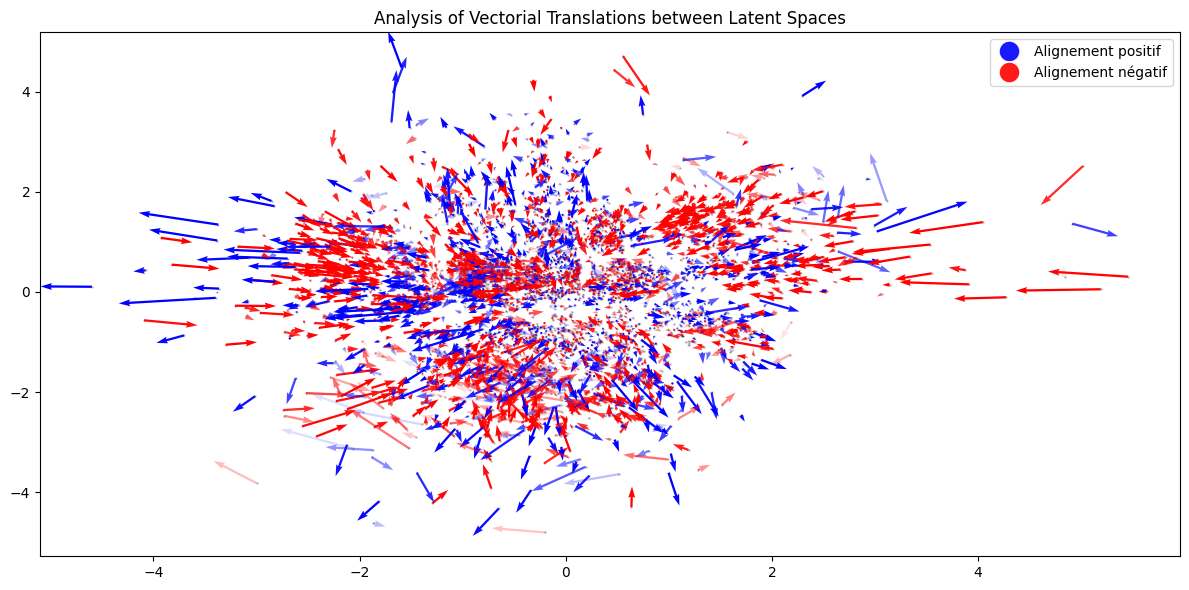

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Assuming new_reparam_subset and new_solutions are already defined
new_reparam_subset = np.array(reparam_subset)
new_solutions = np.array(solutions)

# Define the new mean for vector calculation
new_mean = np.array([-0.123, 0.0281])

####################################################################################################################################################
# Vector Calculations
####################################################################################################################################################

# Calculate the vectors from the mean to the reparam points
vecteurs_mean_to_reparam = new_reparam_subset - new_mean

# Calculate the vectors from reparam points to solutions
vecteurs_reparam_to_solutions = new_solutions - new_reparam_subset

# Calculate the x and y differences (dx, dy) between reparam and solution points
dx = new_solutions[:, 0] - new_reparam_subset[:, 0]
dy = new_solutions[:, 1] - new_reparam_subset[:, 1]

# Normalize the vectors for dot product calculation
norm_vecteurs_mean_to_reparam = vecteurs_mean_to_reparam / np.linalg.norm(vecteurs_mean_to_reparam, axis=1, keepdims=True)
norm_vecteurs_reparam_to_solutions = vecteurs_reparam_to_solutions / np.linalg.norm(vecteurs_reparam_to_solutions, axis=1, keepdims=True)

# Calculate the dot product between the normalized vectors
produit_scalaire = np.sum(norm_vecteurs_mean_to_reparam * norm_vecteurs_reparam_to_solutions, axis=1)

####################################################################################################################################################
# Plot the points and vectors
####################################################################################################################################################

plt.figure(figsize=(12, 6))

# Plot the reparam points as the background context (in gray)
plt.scatter(new_reparam_subset[:, 0], new_reparam_subset[:, 1], s=0.5, color='gray', alpha=0.5)

# Normalize the dot product values for opacity
# Opacity will range from 0.1 to 1.0 based on the normalized absolute value of the dot product
alpha_values = np.abs(produit_scalaire) / np.max(np.abs(produit_scalaire))
alpha_values = 0.1 + 0.9 * alpha_values  # Ensure a minimum opacity of 0.1 for visibility

# Iterate over each point and plot the vectors with color based on alignment
for i in tqdm(range(len(dx))):
    # Determine the color based on the sign of the dot product (blue for positive, red for negative)
    color = 'blue' if produit_scalaire[i] > 0 else 'red'

    # Plot the vector (dx, dy) using quiver, with opacity adjusted by alpha_values
    plt.quiver(new_reparam_subset[i, 0], new_reparam_subset[i, 1], dx[i], dy[i],
               color=color, alpha=alpha_values[i], angles='xy', scale_units='xy', scale=1, width=0.002)

####################################################################################################################################################
# Create the legend
####################################################################################################################################################

# Define handles for the legend to indicate positive and negative alignment
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=15, alpha=0.9, label='Positive alignment'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=15, alpha=0.9, label='Negative alignment')
]

# Add the legend to the plot
plt.legend(handles=legend_handles, loc='upper right')

# Set the plot title and adjust the layout
plt.title("Analysis of Vectorial Translations between Latent Spaces")
plt.tight_layout()

# Display the plot
plt.show()


In [28]:
# Define file paths for the results corresponding to each image and its associated digit (0-9)
filepath_MNIST_results = '/content/drive/My Drive/Thesis/data/MNIST_results.txt' 
filepath_MT_results = '/content/drive/My Drive/Thesis/data/MT_results.txt'
filepath_MN_results = '/content/drive/My Drive/Thesis/data/MN_results.txt'
filepath_MB_results = '/content/drive/My Drive/Thesis/data/MB_results.txt'

# Load the data from the files as NumPy arrays
MNIST_results = np.array(recup_da_floats(filepath_MNIST_results))  # Ground truth (actual digits for the MNIST images)
MT_results = np.array(recup_da_floats(filepath_MT_results))  # Model predictions for the MT model
MN_results = np.array(recup_da_floats(filepath_MN_results))  # Model predictions for the MN model
MB_results = np.array(recup_da_floats(filepath_MB_results))  # Model predictions for the MB model

def accuracy(MNIST, MODEL):
    """
    Calculate the accuracy of the model by comparing the MNIST ground truth with the model's predictions.

    Args:
        MNIST (array): Ground truth labels (actual digits) from the MNIST dataset.
        MODEL (array): Model predictions for the corresponding MNIST images.

    Returns:
        accuracy (list): A list of 1s and 0s, where 1 indicates a correct prediction and 0 indicates an incorrect one.
    """
    accuracy = []
    
    # Iterate over each prediction and compare it with the ground truth
    for i in range(len(MODEL)):
        if MNIST[i] == MODEL[i]:
            accuracy.append(1)  # Correct prediction
        else:
            accuracy.append(0)  # Incorrect prediction

    # Print the accuracy result in a readable format
    correct_predictions = sum(accuracy)
    total_predictions = len(MODEL)
    accuracy_percentage = correct_predictions / total_predictions * 100
    
    print(f"Your model was right {correct_predictions} out of {total_predictions} images (i.e. {accuracy_percentage:.2f}%)")
    
    return accuracy

if __name__ == "__main__":
    # Calculate the accuracy for the MT, MN, and MB models
    accuracy_MT = accuracy(MNIST_results, MT_results)
    accuracy_MN = accuracy(MNIST_results, MN_results)
    accuracy_MB = accuracy(MNIST_results, MB_results)


Your model was right 4176 out of 5000 images (ie. 0.8352 %)
Your model was right 4304 out of 5000 images (ie. 0.8608 %)
Your model was right 4184 out of 5000 images (ie. 0.8368 %)
